# はじめに

[ガウス過程と機械学習](https://www.kspub.co.jp/book/detail/1529267.html)を読んだ．
この記事では自分の理解のために，ガウス過程を実装する．
今のところの理解では，$N_1$個の入力と出力のペア$(x_1^{(1)}, y_1^{(1)}),\dots ,(x_{1}^{(N_1)}, y_{1}^{(N_1)})$と，出力を求めたい$N_2$個の入力$(x_2^{(1)}, y_2^{(1)}),\dots ,(x_{2}^{(N_2)}, y_{2}^{(N_2)})$があるとき，ガウス過程では以下のようにして出力$y_2$の分布を求める．

1. 観測$y_1\in \mathbb R^{N_1}$および$y_2 \in \mathbb R^{N_2}$がある1つの多変量ガウス分布に従うとする．$y = [y_1, y_2]^\top$, $x = [x_1, x_2]^\top$とするとき，$y \sim \mathcal N (\mu(x), \Sigma(x))$．ここで，平均$\mu$および分散$\Sigma$は$x$の関数．
1. $y_1$が得られたときの，$y_2$の条件付き確率分布を求める．

以下では，平均気温の変動を例に実際にガウス過程を書いてみる．

# 気温変動の例

この記事では例として以下のような愛知県の気温の変動について考える．
データは気象庁のHPから入手できる．

はじめに簡単な例として，ある日の気温$y_1$が観測されたときに，次の日の気温$y_2$の確率分布を求める問題を考える．
とりあえず，$y_1$と$y_2$の関係をプロットすると以下．

In [84]:
%matplotlib inline
import numpy as np
import pylab as plt
import pandas as pd
import seaborn as sns
from scipy.stats import multivariate_normal
from random import shuffle

In [85]:
data = pd.read_csv("./data.csv")

In [86]:
data.head()

,年月日,平均気温,Unnamed: 2,Unnamed: 3
0,2016/8/1,27.9,8,1
1,2016/8/2,26.5,8,1
2,2016/8/3,27.9,8,1
3,2016/8/4,29.0,8,1
4,2016/8/5,29.3,8,1


In [87]:
data = pd.read_csv("./data.csv")
data["年月日"] = pd.to_datetime(data["年月日"])
data = data[data["年月日"] < "2018/8/2"]

In [88]:
temperatures = data.values[:, 1].astype(np.float32)

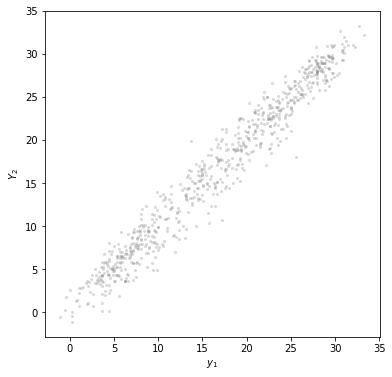

In [104]:
plt.figure(figsize=(6,6))

plt.scatter(temperatures[:-1],temperatures[1:],  alpha=0.3, linewidths=0, marker=".", c="gray")
plt.xlabel("$y_1$")
plt.ylabel("$Y_2$")
plt.show()

散布図よりある日の気温と次の日の気温が相関していることがわかる。
また、全体的に気温の分布はガウス分布っぽくなっている(ということにする)。
以上から、ある日と次の日の気温の分布は多変量ガウス分布によってモデル化することができそうである。

つまり$p(y, y') = \mathcal{N}(\bar{\boldsymbol{y}}, \Sigma)$，ここで、$\bar{\boldsymbol{y}}\in \mathbb R^2$は年間の気温の平均$\bar{y}$を並べたベクトルであり、$\Sigma$は分散共分散行列である。

In [90]:
mean_temperature = np.mean(temperatures)

In [91]:
cov_temperatures = np.cov(np.c_[temperatures[:-1], temperatures[1:]], rowvar=0)

In [92]:
Sigma11, Sigma12, Sigma21, Sigma22 = cov_temperatures.reshape(-1)

In [93]:
display(mean_temperature)
display(cov_temperatures)

16.492613

array([[76.93262956, 75.43887714],
       [75.43887714, 77.04298053]])

データより平均は16ぐらい．
分散共分散行列の成分$\Sigma{11}, \Sigma{22}$はともに年間の気温の分散であり、データより$\Sigma{11}, \Sigma{22} = 77$ぐらいで，共分散$\Sigma{12} = \Sigma{21} = 75$ぐらいであった．

データを多変量ガウス分布でモデル化するのが妥当かをなんとなく見るために，この多変量ガウス分布とデータの分布を比較すると以下のようになる．

In [99]:
x = np.linspace(np.min(temperatures)-5,np.max(temperatures)+5)
y = np.linspace(np.min(temperatures)-5,np.max(temperatures)+5)
XX, YY = np.meshgrid(x,y)

shape = XX.shape
XX = XX.reshape(-1)
YY = YY.reshape(-1)

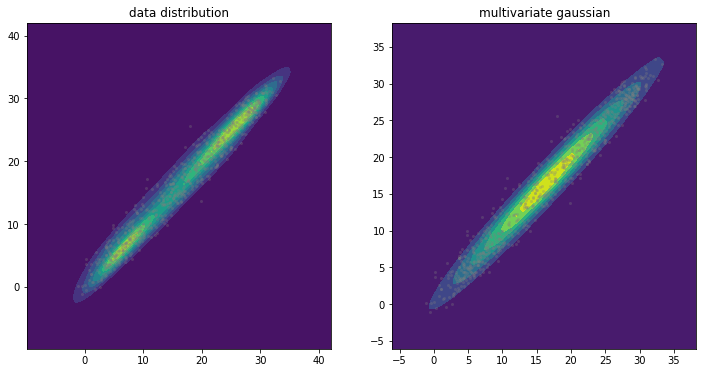

In [101]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.title("data distribution")
sns.kdeplot(temperatures[1:], temperatures[:-1], shade=True, cmap="viridis")
plt.scatter(temperatures[1:], temperatures[:-1], 
            alpha=0.3, linewidths=0, marker=".", c="gray")
plt.subplot(122)
plt.title("multivariate gaussian")
plt.contourf(XX.reshape(shape), YY.reshape(shape), 
            multivariate_normal.pdf(np.array(list(zip(XX, YY))), 
                                    mean=[mean_temperature,mean_temperature], 
                                    cov=cov_temperatures).reshape(shape))
plt.scatter(temperatures[1:], temperatures[:-1], 
            alpha=0.3, linewidths=0, marker=".", c="gray")
plt.show()

(日本の気温は夏と冬で二極化しているので，ガウス分布ではない気もするが) 今回はこれで良しとする．


## 多変量ガウス分布の条件付き確率
ある日の気温$y$と次の日の気温$y'$の同時分布をモデル化することはできた．
次に，ある日の気温$y$が観測されたときの次の日の気温$y'$の確率，つまり，条件付き確率$p(y| y') $を考える．

$y$が観測されたとき，$y'$の条件付き確率は
$p(y' | y) = \mathcal{N}(\Sigma{21}\Sigma{11}^{-1}(y_1-\bar{y}) + \bar{y}, \Sigma{22} - \Sigma{21}\Sigma{11^{-1}}\Sigma{12})$
で与えられる．


In [68]:
from scipy.stats import norm

In [77]:
def conditional_pdf(y1, mean, range_y2=np.arange(-3, 3, 0.1)):
    mean = Sigma21/Sigma11*y1 + mean
    variance = Sigma22 - Sigma21 / Sigma11 * Sigma12
    
    return range_y2, norm.pdf(range_y2, loc=mean, scale=variance) * 30

プロットでこれが結局どのような分布なのかを確認する．
例として，今日の気温が25℃，15℃，5℃であったときの$p(y_2|y_1)$を以下に示す．

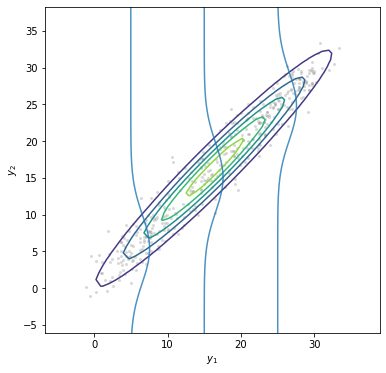

In [78]:
plt.figure(figsize=(6,6))

plt.scatter(temperatures[1:], temperatures[:-1], 
            alpha=0.3, linewidths=0, marker=".", c="gray")
plt.contour(XX.reshape(shape), YY.reshape(shape), 
            multivariate_normal.pdf(np.array(list(zip(XX, YY))), 
                                    mean=[mean_temperature,mean_temperature], 
                                    cov=cov_temperatures).reshape(shape))

for i in np.linspace(5, 25, 3):
    range_y2, pdf = conditional_pdf(i - mean_temperature, 
                                    mean_temperature,
                                    range_y2=np.linspace(np.min(temperatures)-5, np.max(temperatures)+5,100))
    plt.plot(pdf+i, range_y2, c="C0", alpha=0.8)
plt.axis("equal")
plt.xlabel("$y_1$")
plt.ylabel("$y_2$")
plt.show()

ガウス分布では$\Sigma_{11}$と$\Sigma_{21}$が近い値になっているため，$y_1$がある値をとったとき，$y_2$はその値の近くを中心とするガウス分布になることがわかる．

ということで，ここまでである日の気温がわかったとき次の日の気温の分布を求めることができた．

## ガウス過程


ここまではある日の気温とその次の日の気温という2つの変数のみを考えてきた．
一方で，2日前や3日前の気温もその日の気温と関連しているように思える．
また，これらの関連度合いは徐々に小さくなっていくことが予想できる．



この関係性を使って，


このような関係性を使って，



このような関係は，ある日$x_n$と別の日$x_{n'}$の間の気温の共分散を以下のような関数として書くことで表すことができる．
$k(x_n, x_{n'}) = \theta_1 \mathrm{exp}\left(- \frac{|x_n - x_{n'}|}{\theta2} \right)$．
これはガウスカーネル関数であり，これを並べたもの($K_{nn'} = k(x_n, x_{n'})$)をカーネル行列とよぶ．





さて，ここで$N_1$個の入力と出力のペア$(x_1^{(1)}, y_1^{(1)}),\dots ,(x_{1}^{(N_1)}, y_{1}^{(N_1)})$




今のところの理解では，
と，出力を求めたい$N_2$個の入力$(x_2^{(1)}, y_2^{(1)}),\dots ,(x_{2}^{(N_2)}, y_{2}^{(N_2)})$があるとき，ガウス過程では以下のようにして出力$y_2$の分布を求める．

1. 観測$y_1\in \mathbb R^{N_1}$および$y_2 \in \mathbb R^{N_2}$がある1つの多変量ガウス分布に従うとする．$y = [y_1, y_2]^\top$, $x = [x_1, x_2]^\top$とするとき，$y \sim \mathcal N (\mu(x), \Sigma(x))$．ここで，平均$\mu$および分散$\Sigma$は$x$の関数．
1. $y_1$が得られたときの，$y_2$の条件付き確率分布を求める．



これらを統一的にモデル化するために，現在得られている全ての気温の同時分布p(Y, y)を上と同じように多変量ガウス分布によってモデル化し，今日までの気温から明日の気温の条件付き確率$p(y|Y)$を求める方法がある．
これがガウス過程回帰である(たぶん)．

2つの変数だけ考えていた場合と同様にモデル化するためには，各日の気温間の共分散を考える必要がある．
今扱っている気温の例では，これも統計量を求めることができるが，ここでは日付の差($x$)の関数$k(x)$によって共分散を記述できるとする．

ここで，共分散行列を$\Sigma = K + \epsilon \mathbb I$とする．



データをそのまま使っても良いが，ガウス過程の例題としては観測のタイミングがまちまちであるほうが面白そうなので，データをランダムに間引いた．


In [83]:
ids = data.index.values
shuffle(ids)
observed_ids = np.array(sorted(ids[:400]))

data = data.iloc[observed_ids].sort_values("年月日")

temperatures = data.values[:, 1].astype(np.float32)

In [20]:
import torch
from torch import inverse

In [21]:
temperatures = torch.from_numpy(temperatures)
mean_temperature = torch.Tensor([mean_temperature])

In [22]:
def gauss_kernel(x, xd, theta1, theta2):
    k = theta1 * torch.exp(- (x-xd)**2/ theta2)    
    return k

def get_covariance(theta1, theta2, xs, epsilon=0.1):
    cov = []
    for i in xs:
        k = gauss_kernel(
                i,
                torch.Tensor(list(xs)).float(), 
                theta1, theta2
        )
        cov.append(k)
    cov = torch.stack(cov) 
    cov = cov + torch.eye(cov.shape[0])
    return cov

In [23]:
cov = get_covariance(theta1=20, theta2=10, xs=observed_ids)    

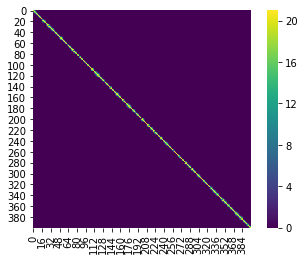

In [24]:
sns.heatmap(cov.data.numpy(), square=True, cmap="viridis")

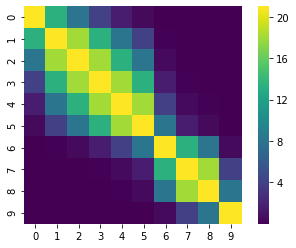

In [25]:
sns.heatmap(cov.data.numpy()[:10, :10], square=True, cmap="viridis")

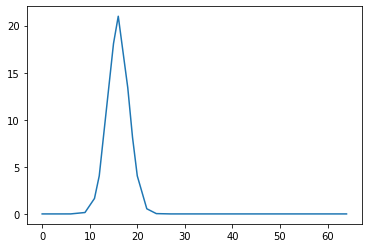

In [26]:
plt.plot(observed_ids[:40], cov.data.numpy()[:40, 10])

In [27]:
def conditional_pdf(theta1, theta2, x1, y1, x2, y2):
    xs = np.r_[x1, x2]
    y1_mean = torch.mean(y1)
      
    cov = get_covariance(theta1, theta2, xs)

    y1_indexes = list(range(len(x1)))
    y2_indexes = list(range(len(x1), len(x1) + len(x2)))
        
    Sigma11 = cov[np.meshgrid(y1_indexes, y1_indexes)]
    Sigma22 = cov[np.meshgrid(y2_indexes, y2_indexes)]
    Sigma12 = cov[np.meshgrid(y2_indexes, y1_indexes)]
    Sigma21 = cov[np.meshgrid(y1_indexes, y2_indexes)]     

    mean = (Sigma21 @ inverse(Sigma11) @ (y1-y1_mean)) + y1_mean
    variance = Sigma22 - Sigma21 @ inverse(Sigma11) @ Sigma12
    norm = torch.distributions.MultivariateNormal(loc=mean, covariance_matrix=variance)
    
    return norm.log_prob(y2)

In [28]:
plot_range_y2 = torch.stack([torch.linspace(torch.min(temperatures)-5, 
                                            torch.max(temperatures)+5, 1000)]).t()

In [29]:
y1_indexes = list(range(len(temperatures)))
y2_indexes = 100

y1 = temperatures[y1_indexes]
y2 = temperatures[y2_indexes]
x1 = observed_ids[y1_indexes]
x2 = observed_ids[y2_indexes]

In [30]:
len(ids)

731

In [31]:
def plot(theta1, theta2):
    list_log_probs = []
    for i in range(len(ids)):
        y1_indexes = list(range(len(temperatures)))
        y1 = temperatures[y1_indexes]
        x1 = observed_ids
        x2 = [i]

        log_probs = conditional_pdf(theta1=theta1, theta2=theta2,
                                x1=np.array(x1), y1=y1,
                                x2=np.array(x2), y2=plot_range_y2)
        list_log_probs.append(log_probs)
    
    XX, YY = np.meshgrid(range(len(ids)), plot_range_y2.data.numpy()[:,0])
    list_log_probs = torch.stack(list_log_probs).data.numpy().T
    
    plt.plot(range(len(ids)),[plot_range_y2[i] for i in  np.argmax(list_log_probs, axis=0)])
    plt.plot(observed_ids, temperatures.data.numpy(), marker=".")
    plt.show()
    
    plt.contourf(XX, YY, np.exp(list_log_probs), alpha=1)
    plt.plot(observed_ids, temperatures.data.numpy(), c="C1")
    plt.show()
    
    plt.contourf(XX, YY, np.exp(list_log_probs), alpha=1)
    plt.plot(observed_ids, temperatures.data.numpy(), c="C1", marker=".")
    plt.xlim(0, 60)
    plt.show()

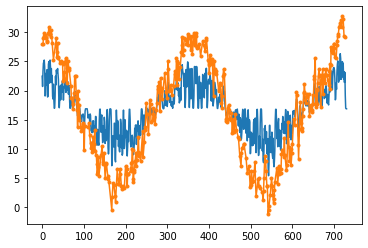

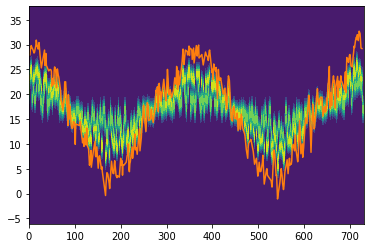

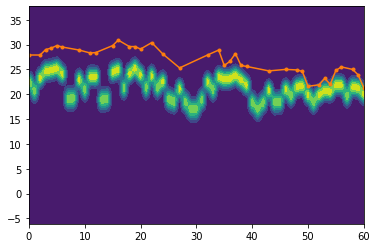

In [33]:
plot(theta1=1, theta2=1)

## カーネルの学習

上では共分散行列をカーネルの形で与えることで，観測データを1つの多変量ガウス分布として表し，各日$x_i$での平均気温の確率$p(y_i|y_{j TODO i})$を求めた．
しかし，適当に与えたカーネルのパラメータでは平均気温の変動を正しく捉えることができていなkった．これはカーネルのパラメータ$\theta1$, $\theta2$を適切な値に設定できていないことが原因である．
そこで，次にこのパラメータを，観測データの対数尤度$\sum_i \log p(y_i|y_{j TODO i};\theta)$を最大化するように，勾配法を用いて更新する．

ここではpytorchを用いて実装する．参考文献ではLBFGSなどで更新するTODOとあったが，ここでは簡単にAdamを使ってパラメータを更新する．
また，$i$を1つずつ設定して更新するのは大変なので，ここでは50点をランダムに選択し(I)，
各更新で$\log p(y_i, i\in I|y_{j TODO I};\theta)$を最大化するようにミニバッチ学習を行った．

In [34]:
from torch.optim import LBFGS, Adam
from random import shuffle

In [35]:
theta1 = torch.Tensor([1]).float()
theta2 = torch.Tensor([1]).float()

In [36]:
theta1.requires_grad = True
theta2.requires_grad = True

In [44]:
optimizer = Adam([theta1, theta2], lr=0.5)

minibatch_size = 100

In [45]:
observed_ids.shape

(400,)

In [46]:
hist_theta1 = []
hist_theta2 = []
hist_log_probs = []

for i in range(1000):
    hist_theta1.append(float(theta1.data.numpy()))
    hist_theta2.append(float(theta2.data.numpy()))
    
    random_ids = list(range(len(temperatures)))
    shuffle(random_ids)
    y2_ids = random_ids[:minibatch_size]
    y1_ids = random_ids
    log_probs = conditional_pdf(theta1, theta2, 
                                observed_ids[y1_ids], temperatures[y1_ids], 
                                observed_ids[y2_ids], temperatures[y2_ids])

    optimizer.zero_grad()
    (-log_probs).backward()
    optimizer.step()
    
    hist_log_probs.append(log_probs.data.numpy())


In [47]:
theta1, theta2

(tensor([ 55.1354]), tensor([ 3.8571]))

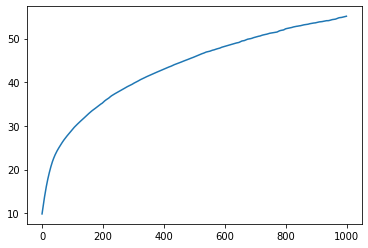

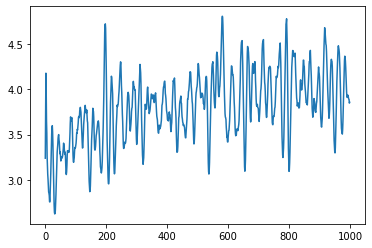

In [48]:
plt.plot(hist_theta1)
plt.show()
plt.plot(hist_theta2)
plt.show()

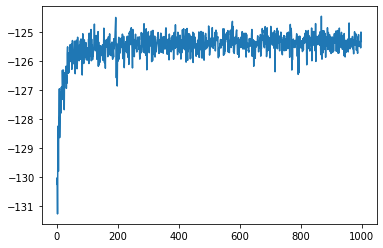

In [49]:
plt.plot(hist_log_probs)

更新後のパラメータ$\theta1$, $\theta2$を用いて，再び各日での確率を求めると以下．

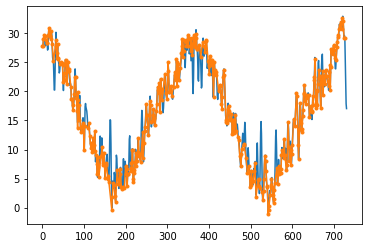

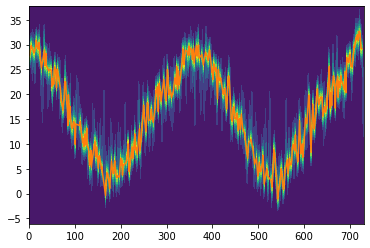

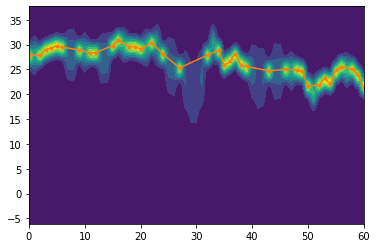

In [50]:
plot(theta1=theta1, theta2=theta2)

無事に実際の観測をモデル化できていそうなパラメータを獲得できていることがわかる．